




<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 02 - Part 1
<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div><br>

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

<div class="alert alert-block alert-info">
<b>The CIFAR-10 dataset</b><br>
https://www.cs.toronto.edu/~kriz/cifar.html
    </div>

## Import packages needed 

In [1]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Verify TensorFlow Version and Keras Version

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0


In [4]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


## Mount Google Drive to Colab Environment

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

## Functions for Research Assignment

In [5]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [6]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [7]:
def compile_train_model(model, x_train, y_train, x_valid, y_valid, epochs=200):
  timestamp=int(time.time())
  
  # Compile
  model.compile(optimizer='rmsprop',
                loss = 'SparseCategoricalCrossentropy',
                metrics=['accuracy'])

  # Train
  start_time = time.time()
  history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=512,
    validation_data=(x_valid, y_valid),
    #verbose=0,
    callbacks=[    
        EarlyStopping(monitor='val_accuracy', patience=3),
        ModelCheckpoint('results/model_{val_accuracy:.4f}.h5',
                               save_best_only=True,
                               save_weights_only=False,
                               monitor='val_accuracy')]
  )
  end_time = time.time()
  second_elapsed = round(end_time - start_time)

  print(f'Finished model training in {second_elapsed}s')

  print('Model performance with training set')
  model.evaluate(x_train, y_train)

  print('Evaluating model performance with validation set')
  model.evaluate(x_valid, y_valid)

  return history, model

## Loading cifar10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.<br>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of color image data with shapes (num_samples, 32, 32).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)

## EDA Training and Test Datasets

* Imported 50000 examples for training and 10000 examples for test 
* Imported 50000 labels for training and 10000 labels for test 

In [9]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


## Review labels for training dataset

In [10]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


## Plot Examples

In [11]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [12]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [13]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

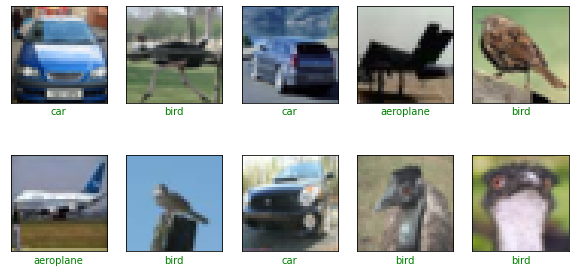

In [14]:
class_names_preview = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_preview, y_preview, y_preview)

## Preprocessing Data for Model Development

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [15]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

#['frog' 'truck' 'deer' 'automobile' 'bird' 'horse' 'ship' 'cat' 'dog'
# 'airplane']

## Create Validation Data Set

In [16]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

## Confirm Datasets {Train, Validation, Test}

In [17]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


## Rescale Examples  {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255
 

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [18]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

## Create the Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/CNN_architecture_v4.png?raw=1">


## Build CNN Model

We use a Sequential class defined in Keras to create our model. The first 9 layers Conv2D MaxPooling, Dropout handle feature learning.  The last 3 layers, handle classification

In [19]:
model = models.Sequential()
model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model.add(layers.MaxPool2D((2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(units=384, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(layers.Dense(units=10, activation=tf.nn.softmax))

Metal device set to: Apple M1 Pro


2022-04-18 20:48:14.674768: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-18 20:48:14.676046: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 512)       14336     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 512)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 512)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       1179904   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 256)         0

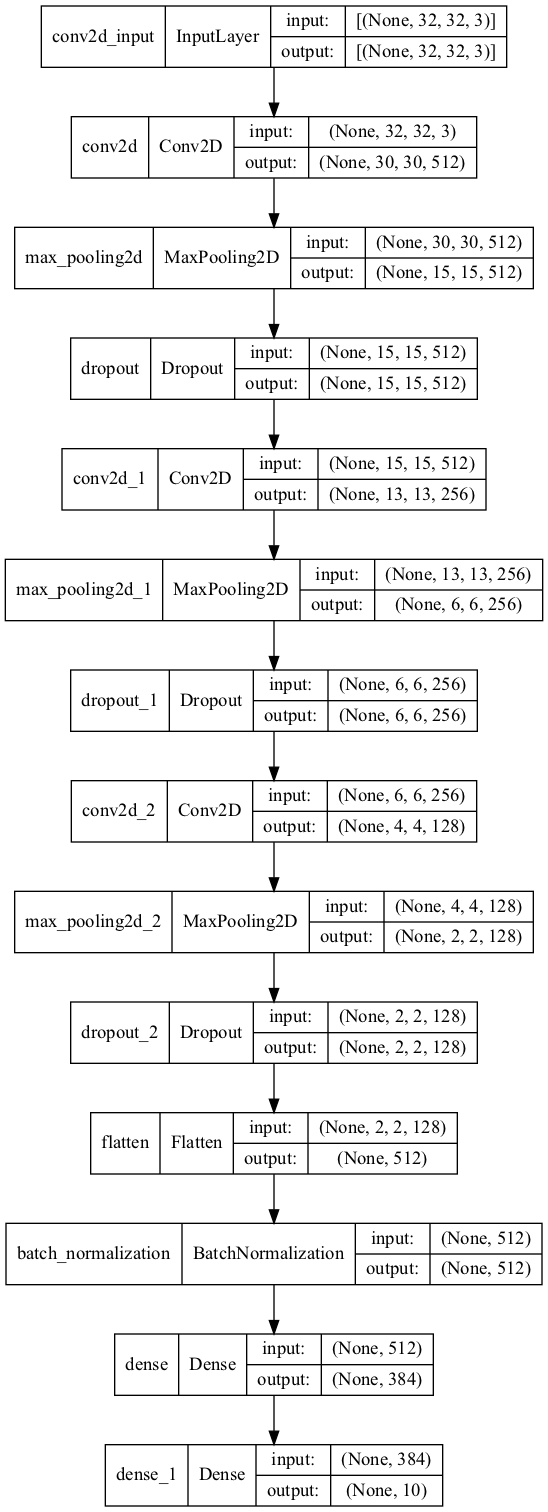

In [21]:
keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True) 

## Compiling the model

In addition to setting up our model architecture, we also need to define which algorithm should the model use in order to optimize the weights and biases as per the given data. We will use stochastic gradient descent.

We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimised in order to have a higher model accuracy. That's what the optimization algorithm essentially does - it minimises the loss during model training. For our multi-class classification problem, categorical cross entropy is commonly used.

Finally, we will use the accuracy during training as a metric to keep track of as the model trains.

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

## Training the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [23]:
history = model.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=512
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    tf.keras.callbacks.ModelCheckpoint('results/model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

2022-04-18 21:20:58.009521: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/200


2022-04-18 21:20:59.183383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - ETA: 0s - loss: 2.1715 - accuracy: 0.3333

2022-04-18 21:26:10.617075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 316s 4s/step - loss: 2.1715 - accuracy: 0.3333 - val_loss: 2.2884 - val_accuracy: 0.3998
Epoch 2/200
88/88 [==============================] - 318s 4s/step - loss: 1.6023 - accuracy: 0.5060 - val_loss: 1.9875 - val_accuracy: 0.4892
Epoch 3/200
88/88 [==============================] - 262s 3s/step - loss: 1.3585 - accuracy: 0.5785 - val_loss: 1.7050 - val_accuracy: 0.5306
Epoch 4/200
88/88 [==============================] - 246s 3s/step - loss: 1.2146 - accuracy: 0.6180 - val_loss: 1.4643 - val_accuracy: 0.5894
Epoch 5/200
88/88 [==============================] - 240s 3s/step - loss: 1.1065 - accuracy: 0.6504 - val_loss: 1.1887 - val_accuracy: 0.6386
Epoch 6/200
88/88 [==============================] - 232s 3s/step - loss: 1.0293 - accuracy: 0.6724 - val_loss: 1.1450 - val_accuracy: 0.6164
Epoch 7/200
88/88 [==============================] - 219s 2s/step - loss: 0.9591 - accuracy: 0.6930 - val_loss: 0.9833 - val_accuracy: 0.6776
Epoch 8/200
88/88 

## Validation Data
Data on which to evaluate the loss and any model metrics at the end of each epoch<br>
The model will not be trained on this data

## Evaluate the model

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [24]:
loss, accuracy = model.evaluate(x_test_norm, y_test)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 5s 15ms/step - loss: 0.6938 - accuracy: 0.7838
test set accuracy:  78.38000655174255


## Predictions

In [25]:
preds = model.predict(x_test_norm)
print('shape of preds: ', preds.shape)

2022-04-19 07:53:09.507526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


shape of preds:  (10000, 10)


## Plotting Performance Metrics 

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [26]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
20,0.620,0.803,0.700,0.776
21,0.614,0.804,0.658,0.796
22,0.606,0.810,0.689,0.785
23,0.595,0.814,0.710,0.778
24,0.590,0.815,0.664,0.792


In [28]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

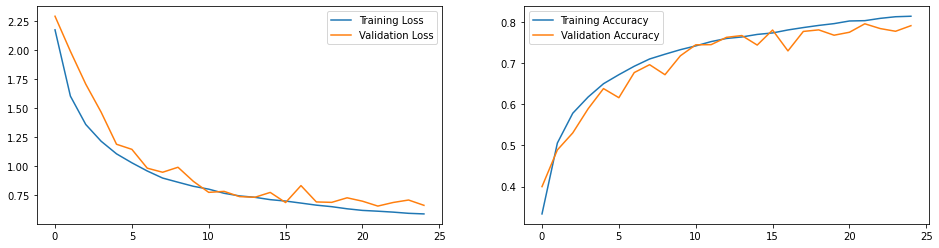

In [29]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [30]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

In [31]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.78      0.82      1000
           1       0.93      0.87      0.90      1000
           2       0.78      0.62      0.69      1000
           3       0.68      0.57      0.62      1000
           4       0.70      0.81      0.75      1000
           5       0.67      0.77      0.72      1000
           6       0.71      0.93      0.80      1000
           7       0.90      0.74      0.81      1000
           8       0.80      0.91      0.85      1000
           9       0.90      0.84      0.87      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000

Accuracy Score: 0.7838
Root Mean Square Error: 1.8562327440275372


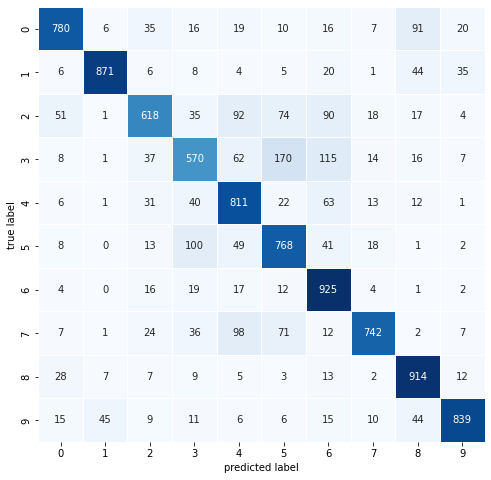

In [32]:
plot_confusion_matrix(y_test,pred1)

## Load HDF5 Model Format 

<div class="alert alert-block alert-info">
<b>tf.keras.models.load_model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model</div>

In [34]:
model = tf.keras.models.load_model('results/model_0.7964.h5')

In [35]:
preds = model.predict(x_test_norm)

2022-04-19 07:54:35.745687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [36]:
preds.shape

(10000, 10)

## Predictions

In [37]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [38]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,0.15%,0.05%,0.45%,88.18%,0.16%,9.72%,1.06%,0.18%,0.03%,0.02%
1,0.95%,5.28%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,93.76%,0.02%
2,1.64%,16.61%,0.88%,0.26%,0.01%,0.04%,0.44%,0.08%,78.62%,1.42%
3,72.08%,3.62%,2.02%,0.45%,0.46%,0.03%,0.22%,0.01%,20.88%,0.21%
4,0.00%,0.01%,1.94%,0.16%,4.39%,0.01%,93.49%,0.00%,0.00%,0.00%
5,0.00%,0.04%,0.01%,0.34%,0.01%,0.17%,99.41%,0.00%,0.01%,0.01%
6,0.04%,84.92%,0.00%,0.01%,0.00%,0.01%,0.03%,0.00%,0.00%,14.99%
7,0.05%,0.00%,9.88%,3.51%,5.07%,0.30%,81.17%,0.01%,0.01%,0.00%
8,0.00%,0.00%,0.62%,95.29%,1.36%,1.87%,0.77%,0.09%,0.00%,0.00%
9,0.05%,89.04%,0.01%,0.00%,0.00%,0.00%,0.13%,0.00%,0.41%,10.35%


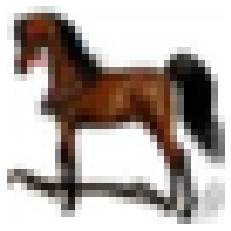

In [39]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [40]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [41]:
activations = activation_model.predict(img_tensor)
len(activations)

2022-04-19 07:56:06.279604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8

In [42]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'dropout',
 'conv2d_1',
 'max_pooling2d_1',
 'dropout_1',
 'conv2d_2',
 'max_pooling2d_2',
 'dropout_2',
 'flatten',
 'batch_normalization',
 'dense',
 'dense_1']

/var/folders/cj/b27zth7d1gn3ktvbyzc3h69c0000gn/T/ipykernel_82609/1872159762.py:28: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


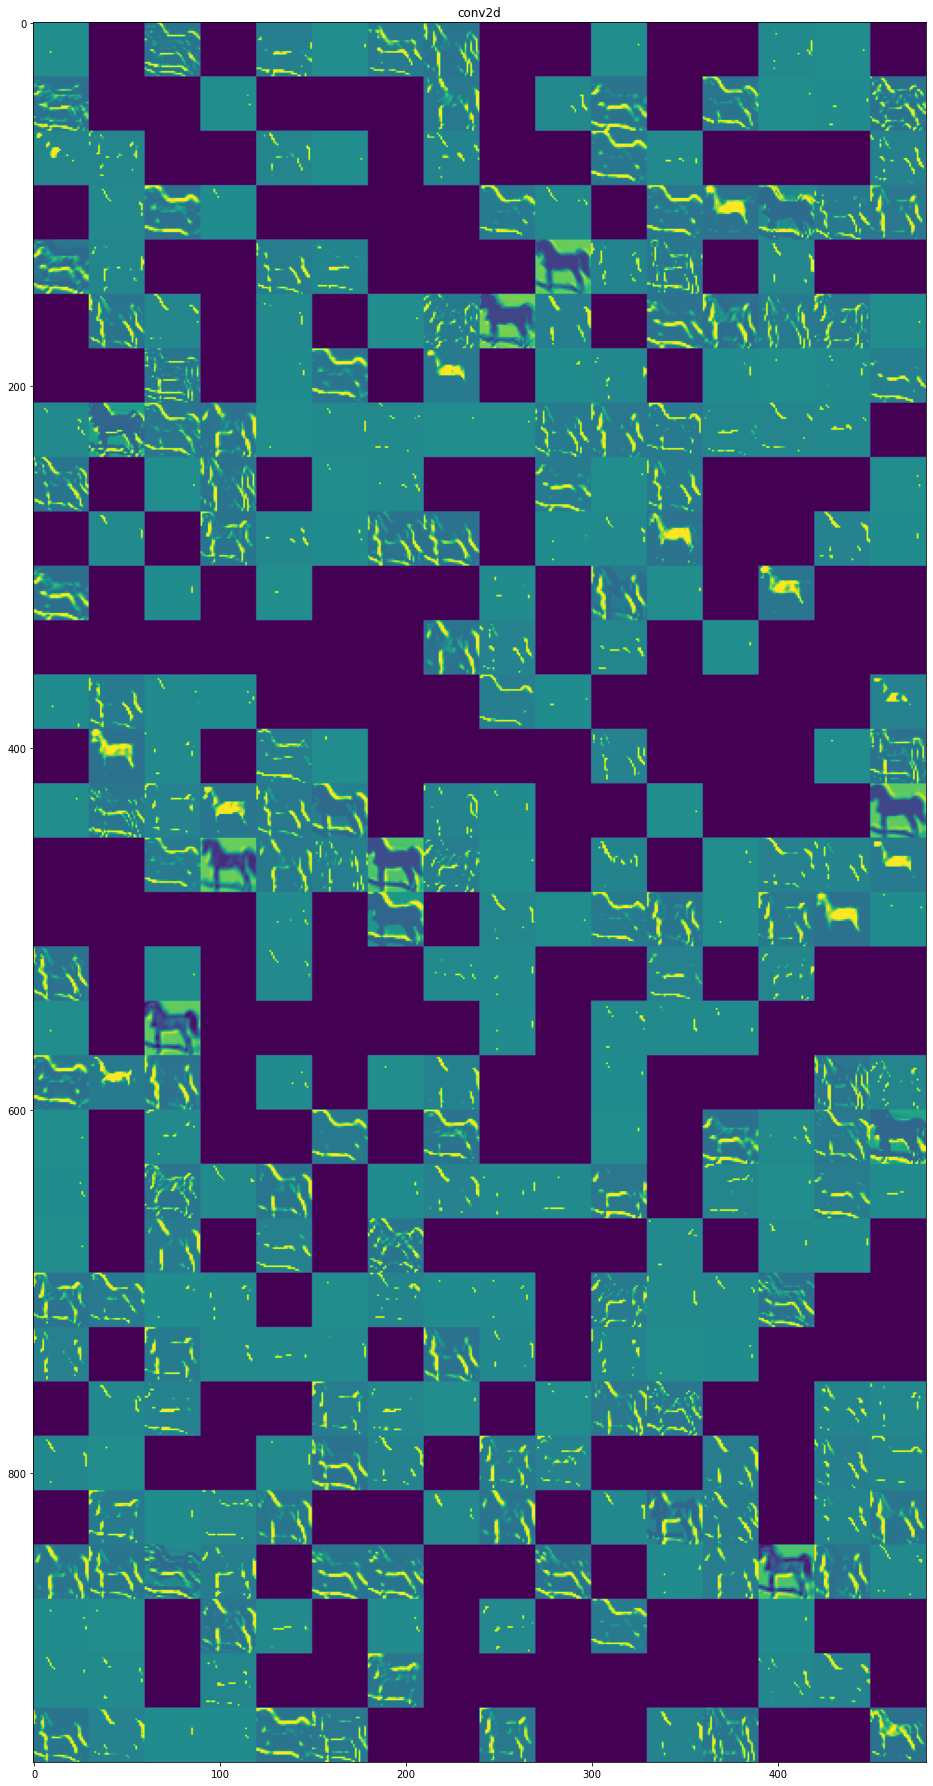

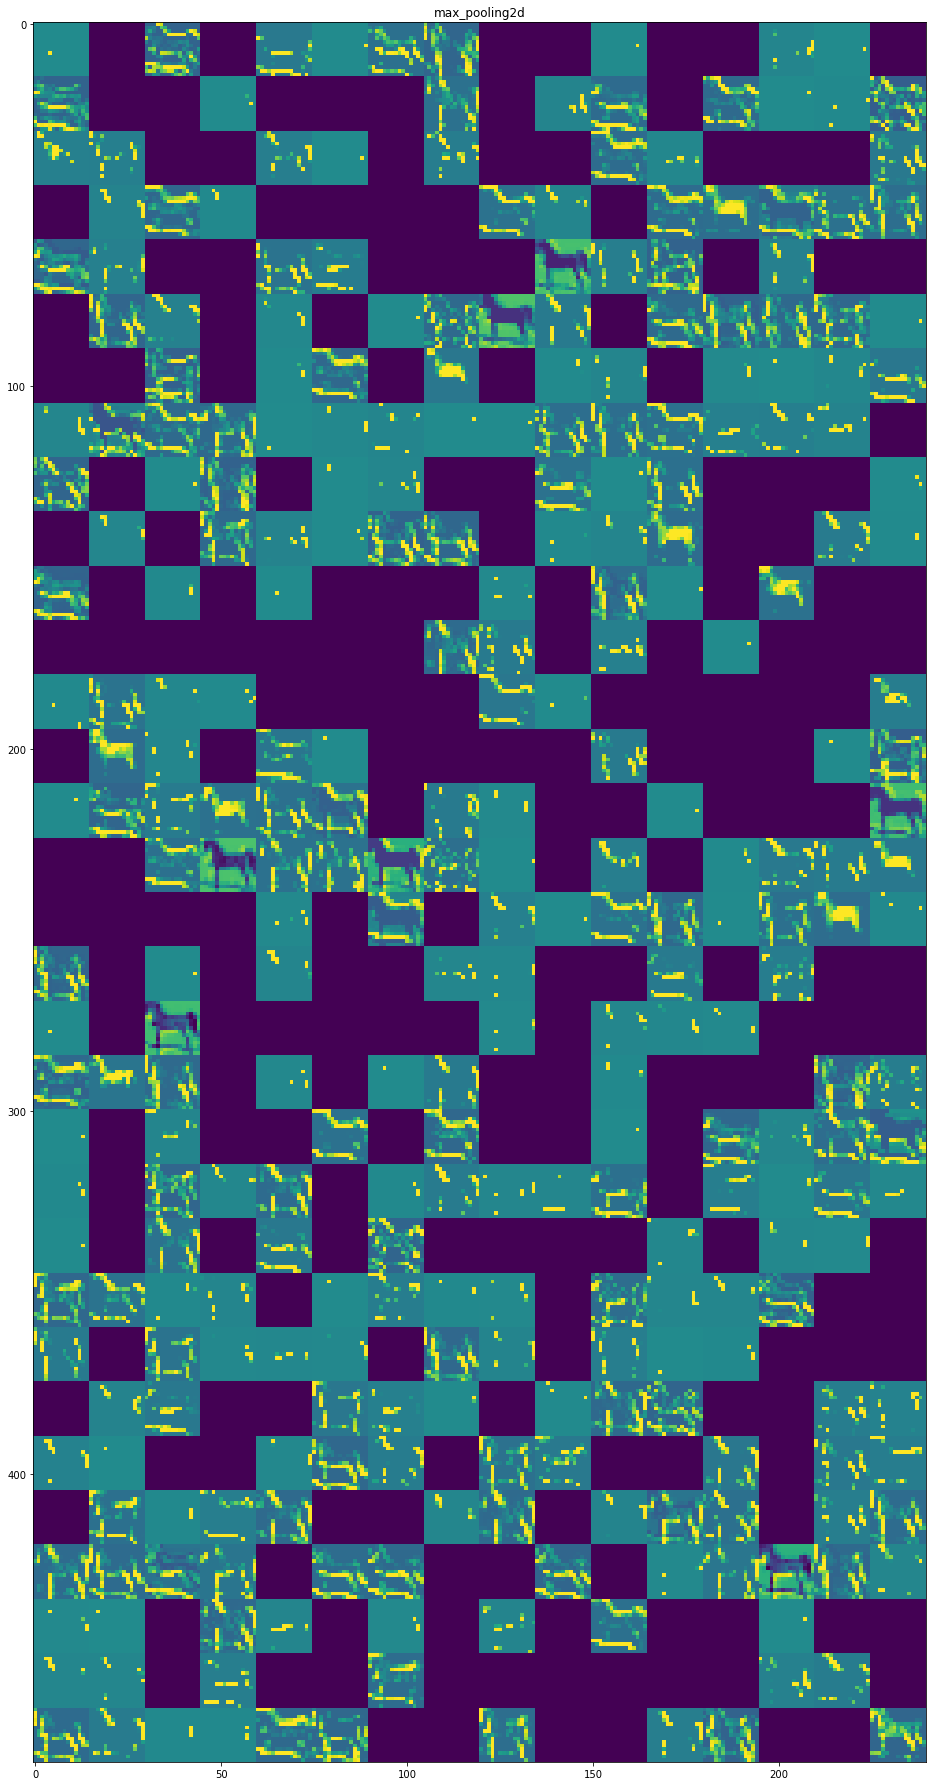

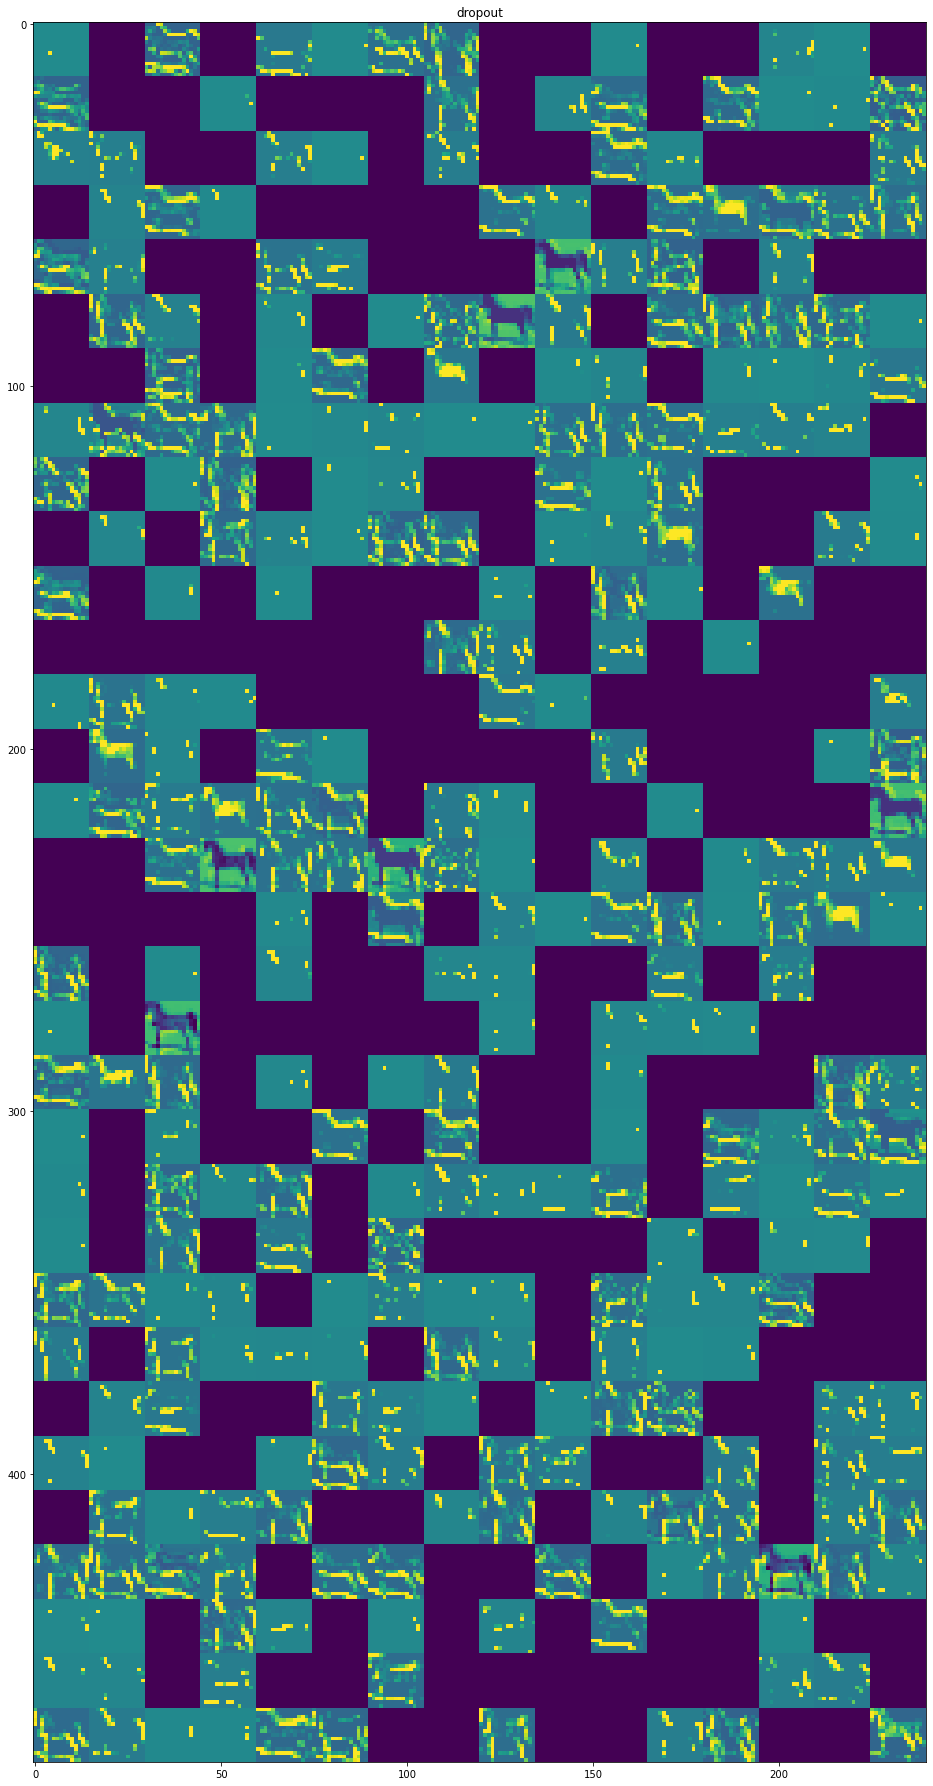

In [43]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();

# Assignment 1 
2 Layer DNN with no regularization

In [96]:
# A method to create and run the models

import warnings
warnings.filterwarnings("ignore")

tf.autograph.set_verbosity(0)
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("scikeras").setLevel(logging.ERROR)

import random


def create_model_dnn(layers=1, nodes=200, init='glorot_uniform', activation=tf.nn.elu):
    
    
    all_layers = [tf.keras.layers.InputLayer(input_shape=(32, 32, 3))]
    
    # Flatten the layers
    all_layers.append(tf.keras.layers.Flatten())
    
    # Add any number of hidden layers
    first = True
    for i in range(layers):
        if first:
            all_layers.append(tf.keras.layers.Dense(nodes, kernel_initializer=init, activation=activation))
            first = False
        else:
            all_layers.append(tf.keras.layers.Dense(nodes, kernel_initializer=init, activation=activation))
    
    # Add the output layer                                     
    all_layers.append(tf.keras.layers.Dense(10, activation='softmax'))
    
    #Create the model
    model = tf.keras.Sequential(all_layers)
    
    #And compile
    model.compile(tf.optimizers.Adam(), 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                  metrics=['accuracy'])
    
    return model

def run_dnn(layers=1, nodes=1, epochs=100):
    
    
    classifier = KerasClassifier(build_fn=lambda: create_model_dnn(layers=layers,
                                                                   nodes=nodes, 
                                                                   init='glorot_uniform'), 
                                 callbacks=[EarlyStopping(patience=4, verbose=5, mode="auto")],
                                 verbose=0)
    
    start_time = timeit.default_timer()
    fit_hist = classifier.fit(x_train_norm,
                              y_train_split,
                              validation_data=(x_valid_norm, y_valid_split),
                              epochs=epochs, 
                              batch_size=200, 
                              verbose=0)
    stop_time = timeit.default_timer()


    print("Keras model with layers {num_layers} and nodes {num_nodes} fit time: {time}".format(time=round(stop_time - start_time, 2),
                                                                         num_layers=layers,
                                                                         num_nodes=nodes))
    
    
    
    return classifier, fit_hist

# One 384 nodes and two layers
clf, hist = run_dnn(layers=2, nodes=384)

2022-05-01 11:42:22.803979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 11:42:29.413467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 19: early stopping
Keras model with layers 2 and nodes 384 fit time: 59.66


In [99]:
pred1 = clf.predict(x_test_norm)
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.65      0.51      0.57      1000
           1       0.55      0.75      0.63      1000
           2       0.43      0.41      0.42      1000
           3       0.38      0.28      0.32      1000
           4       0.46      0.44      0.45      1000
           5       0.46      0.45      0.46      1000
           6       0.55      0.66      0.60      1000
           7       0.49      0.71      0.58      1000
           8       0.70      0.63      0.66      1000
           9       0.66      0.44      0.53      1000

    accuracy                           0.53     10000
   macro avg       0.53      0.53      0.52     10000
weighted avg       0.53      0.53      0.52     10000

Accuracy Score: 0.5268
Root Mean Square Error: 3.0038974682901545


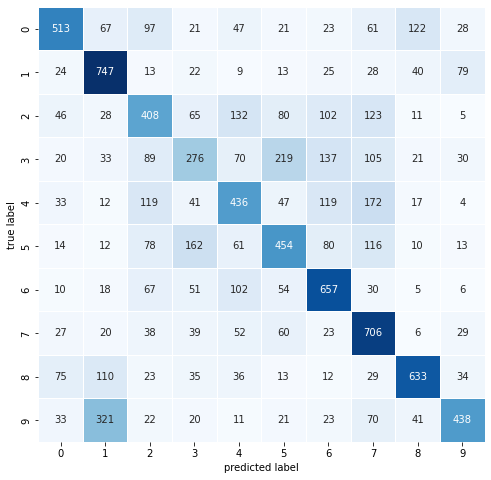

In [100]:
plot_confusion_matrix(y_test,pred1)

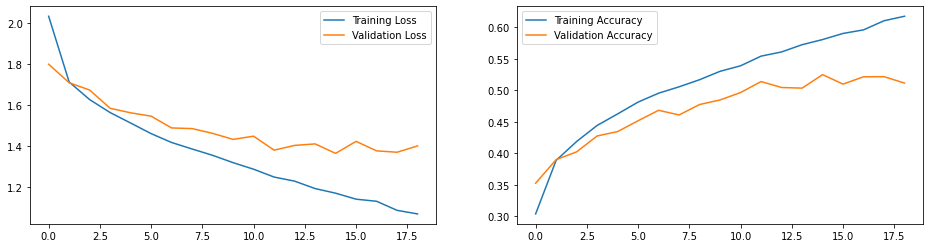

In [103]:
def plot_hist(hist):
    history = hist.history

    loss = history['loss']
    val_loss = history['val_loss']
    
    acc = history['accuracy']
    val_acc = history['val_accuracy']

    epochs_range = len(history['loss'])
    
    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([loss, acc], [val_loss, val_acc], ['Loss', 'Accuracy'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs_range), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs_range), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()

plot_hist(hist)

# Assignment 2
3 Layer DNN with no regularization

In [105]:
# One 384 nodes and three layers
clf, hist = run_dnn(layers=3, nodes=384)

2022-05-01 15:10:13.040478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 15:10:19.267892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 19: early stopping
Keras model with layers 3 and nodes 384 fit time: 68.3


In [106]:
pred1 = clf.predict(x_test_norm)
print_validation_report(y_test, pred1)

2022-05-01 15:11:14.018345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.58      0.58      1000
           1       0.73      0.52      0.61      1000
           2       0.40      0.49      0.44      1000
           3       0.35      0.37      0.36      1000
           4       0.48      0.38      0.42      1000
           5       0.45      0.45      0.45      1000
           6       0.62      0.55      0.58      1000
           7       0.59      0.63      0.61      1000
           8       0.61      0.69      0.65      1000
           9       0.58      0.64      0.61      1000

    accuracy                           0.53     10000
   macro avg       0.54      0.53      0.53     10000
weighted avg       0.54      0.53      0.53     10000

Accuracy Score: 0.5298
Root Mean Square Error: 2.9656871041969346


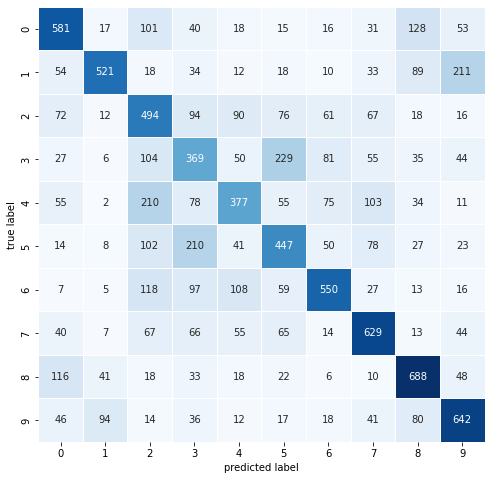

In [107]:
plot_confusion_matrix(y_test,pred1)

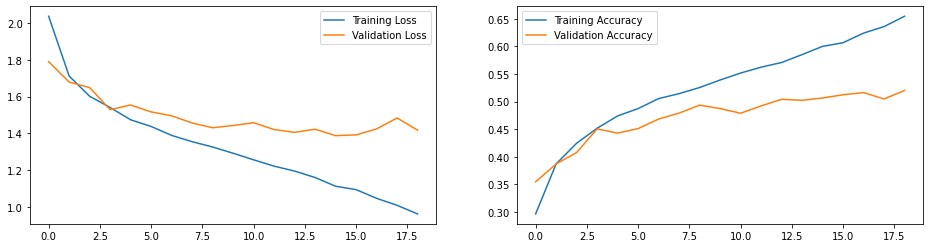

In [108]:
plot_hist(hist)

## Assignment 3

CNN with 2 convolution/max pooling layers (no regularization) and one dense layer

In [109]:
model_single = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Flatten(),
  Dense(units=384,activation=tf.nn.elu),
  Dense(units=10, activation=tf.nn.softmax)       
])

model_single.summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_123 (Conv2D)         (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_123 (MaxPooli  (None, 15, 15, 128)      0         
 ng2D)                                                           
                                                                 
 conv2d_124 (Conv2D)         (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_124 (MaxPooli  (None, 6, 6, 256)        0         
 ng2D)                                                           
                                                                 
 flatten_43 (Flatten)        (None, 9216)              0         
                                                                 
 dense_101 (Dense)           (None, 384)             

In [110]:
# Compile and train
history, model_single = compile_train_model(model_single,
                                     x_train_norm, y_train_split,
                                     x_valid_norm, y_valid_split
                                    )

Epoch 1/200


2022-05-01 16:36:40.920820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - ETA: 0s - loss: 1.9788 - accuracy: 0.3340

2022-05-01 16:37:01.571405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 33s 171ms/step - loss: 1.9788 - accuracy: 0.3340 - val_loss: 1.7529 - val_accuracy: 0.3856
Epoch 2/200
88/88 [==============================] - 14s 152ms/step - loss: 1.4792 - accuracy: 0.4864 - val_loss: 1.6488 - val_accuracy: 0.4110
Epoch 3/200
88/88 [==============================] - 12s 134ms/step - loss: 1.2497 - accuracy: 0.5680 - val_loss: 1.3629 - val_accuracy: 0.5118
Epoch 4/200
88/88 [==============================] - 12s 128ms/step - loss: 1.1097 - accuracy: 0.6184 - val_loss: 1.2276 - val_accuracy: 0.5774
Epoch 5/200
88/88 [==============================] - 11s 127ms/step - loss: 1.0153 - accuracy: 0.6507 - val_loss: 1.0641 - val_accuracy: 0.6332
Epoch 6/200
88/88 [==============================] - 11s 127ms/step - loss: 0.9350 - accuracy: 0.6790 - val_loss: 0.9576 - val_accuracy: 0.6722
Epoch 7/200
88/88 [==============================] - 11s 127ms/step - loss: 0.8695 - accuracy: 0.7047 - val_loss: 0.9401 - val_accuracy: 0.6834
Epoc

In [112]:
pred1 = model_single.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.76      0.62      0.68      1000
           1       0.73      0.86      0.79      1000
           2       0.48      0.63      0.54      1000
           3       0.56      0.42      0.48      1000
           4       0.57      0.62      0.59      1000
           5       0.70      0.45      0.54      1000
           6       0.56      0.87      0.68      1000
           7       0.66      0.80      0.72      1000
           8       0.86      0.70      0.77      1000
           9       0.91      0.58      0.71      1000

    accuracy                           0.65     10000
   macro avg       0.68      0.65      0.65     10000
weighted avg       0.68      0.65      0.65     10000

Accuracy Score: 0.6538
Root Mean Square Error: 2.4161746625606355


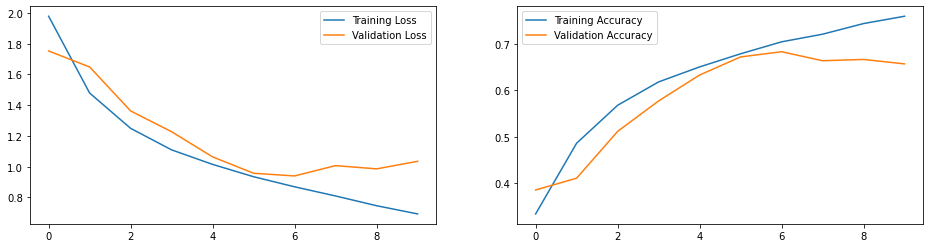

In [113]:
plot_hist(history)

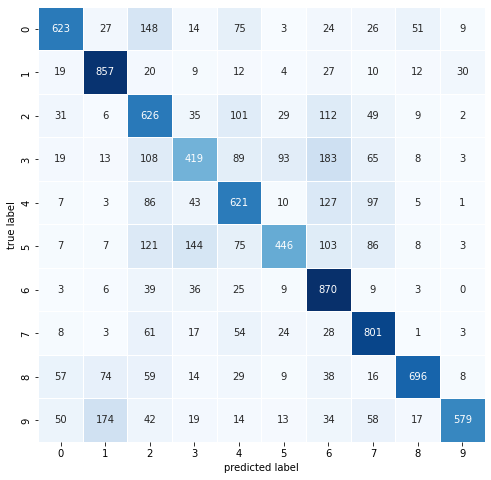

In [114]:
plot_confusion_matrix(y_test, pred1)

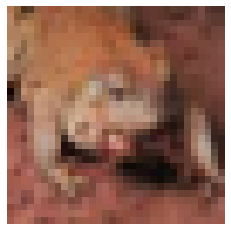

In [134]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[5]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

2022-05-01 17:43:03.982748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


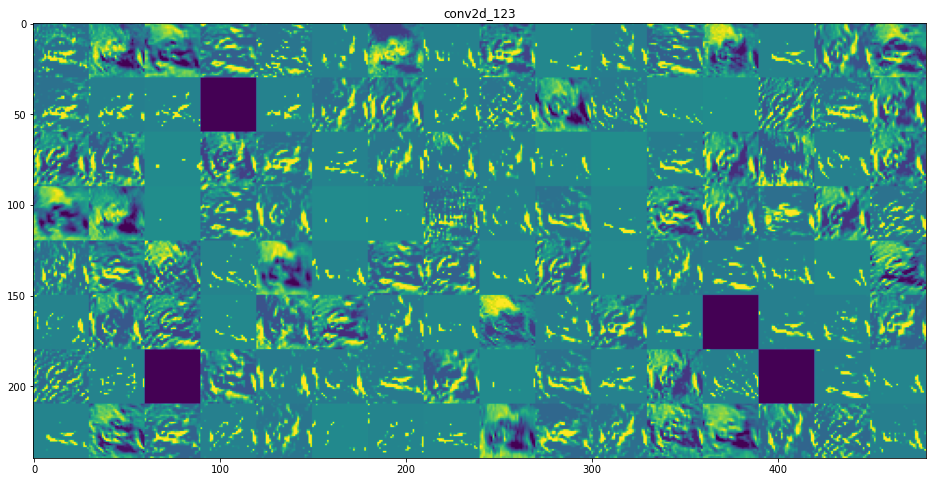

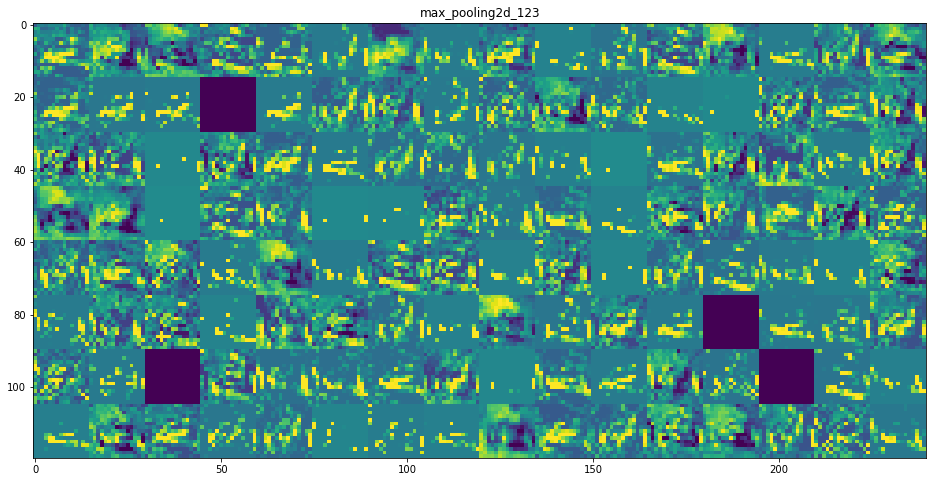

In [137]:
# Now lets look at the activation layers

def draw_tiles(model):
    # Extracts the outputs of the top 4 layers:
    layer_outputs = [layer.output for layer in model.layers[:4]]
    # Creates a model that will return these outputs, given the model input:
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

    activations = activation_model.predict(img_tensor)

    # These are the names of the layers, so can have them as part of our plot
    layer_names = []
    for layer in model.layers[:2]:
        layer_names.append(layer.name)

    images_per_row = 16

    # Now let's display our feature maps
    for layer_name, layer_activation in zip(layer_names, activations):
        # This is the number of features in the feature map
        n_features = layer_activation.shape[-1]

        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]

        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

    plt.show();
    
draw_tiles(model_single)

## Assignment 4

CNN with 3 convolution/max pooling layers (no regularization) and one dense layer

In [138]:
model_double = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Flatten(),
  Dense(units=384,activation=tf.nn.elu),
  Dense(units=10, activation=tf.nn.softmax)       
])

model_double.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_125 (Conv2D)         (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_125 (MaxPooli  (None, 15, 15, 128)      0         
 ng2D)                                                           
                                                                 
 conv2d_126 (Conv2D)         (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_126 (MaxPooli  (None, 6, 6, 256)        0         
 ng2D)                                                           
                                                                 
 conv2d_127 (Conv2D)         (None, 4, 4, 512)         1180160   
                                                                 
 max_pooling2d_127 (MaxPooli  (None, 2, 2, 512)      

In [139]:
# Compile and train
history, model_double = compile_train_model(model_double,
                                     x_train_norm, y_train_split,
                                     x_valid_norm, y_valid_split
                                    )

Epoch 1/200


2022-05-01 17:45:53.696170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - ETA: 0s - loss: 2.1762 - accuracy: 0.2348

2022-05-01 17:46:46.455736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 55s 534ms/step - loss: 2.1762 - accuracy: 0.2348 - val_loss: 1.8618 - val_accuracy: 0.3338
Epoch 2/200
88/88 [==============================] - 56s 631ms/step - loss: 1.7216 - accuracy: 0.3900 - val_loss: 1.5795 - val_accuracy: 0.4388
Epoch 3/200
88/88 [==============================] - 46s 520ms/step - loss: 1.4429 - accuracy: 0.4941 - val_loss: 1.2202 - val_accuracy: 0.5706
Epoch 4/200
88/88 [==============================] - 27s 297ms/step - loss: 1.2591 - accuracy: 0.5626 - val_loss: 1.1235 - val_accuracy: 0.5970
Epoch 5/200
88/88 [==============================] - 45s 508ms/step - loss: 1.1032 - accuracy: 0.6183 - val_loss: 1.2170 - val_accuracy: 0.6048
Epoch 6/200
88/88 [==============================] - 61s 683ms/step - loss: 0.9882 - accuracy: 0.6634 - val_loss: 1.1360 - val_accuracy: 0.6070
Epoch 7/200
88/88 [==============================] - 50s 566ms/step - loss: 0.8805 - accuracy: 0.7013 - val_loss: 0.9050 - val_accuracy: 0.6856
Epoc

In [140]:
pred1 = model_double.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)
print_validation_report(y_test, pred1)

2022-05-01 19:04:36.455050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Classification Report
              precision    recall  f1-score   support

           0       0.79      0.78      0.78      1000
           1       0.85      0.82      0.83      1000
           2       0.76      0.54      0.63      1000
           3       0.53      0.53      0.53      1000
           4       0.71      0.65      0.68      1000
           5       0.50      0.77      0.60      1000
           6       0.81      0.77      0.79      1000
           7       0.77      0.75      0.76      1000
           8       0.87      0.77      0.82      1000
           9       0.77      0.83      0.80      1000

    accuracy                           0.72     10000
   macro avg       0.74      0.72      0.72     10000
weighted avg       0.74      0.72      0.72     10000

Accuracy Score: 0.7206
Root Mean Square Error: 2.137381575666825


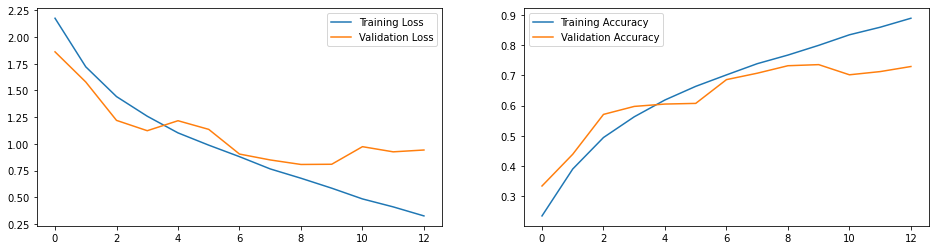

In [141]:
plot_hist(history)

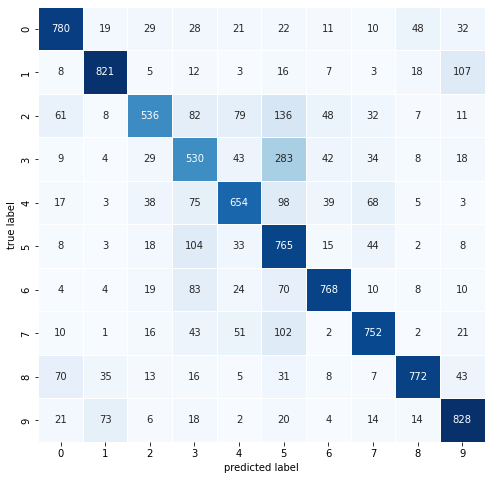

In [142]:
plot_confusion_matrix(y_test, pred1)

# Additional Assignment

Create a ensemble of CNN models and then average the results of all the models for the final result.

We will also use data augmentation to enhanhance the training set.

In [19]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from scipy import stats
import sklearn
import types


class KerasBatchClassifier(KerasClassifier):
    

    def fit(self, X, y, **kwargs):
        
        y = np.array(y)
        if len(y.shape) == 2 and y.shape[1] > 1:
            self.classes_ = np.arange(y.shape[1])
        elif (len(y.shape) == 2 and y.shape[1] == 1) or len(y.shape) == 1:
            self.classes_ = np.unique(y)
            y = np.searchsorted(self.classes_, y)
        else:
            raise ValueError('Invalid shape for y: ' + str(y.shape))
        self.n_classes_ = len(self.classes_)

        # taken from keras.wrappers.scikit_learn.KerasClassifier.fit ###################################################
        if self.build_fn is None:
            self.model = self.__call__(**self.filter_sk_params(self.__call__))
        elif not isinstance(self.build_fn, types.FunctionType) and not isinstance(self.build_fn, types.MethodType):
            self.model = self.build_fn(**self.filter_sk_params(self.build_fn.__call__))
        else:
            self.model = self.build_fn(**self.filter_sk_params(self.build_fn))

        loss_name = self.model.loss
        if hasattr(loss_name, '__name__'):
            loss_name = loss_name.__name__

        if loss_name == 'categorical_crossentropy' and len(y.shape) != 2:
            y = to_categorical(y)

        ################################################################################################################


        datagen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        batch_size = 50
        if 'batch_size' in kwargs:
            batch_size = kwargs['batch_size']
            

        if 'X_val' in kwargs and 'y_val' in kwargs:
            X_val = kwargs['X_val']
            y_val = kwargs['y_val']

            val_gen = ImageDataGenerator(
                horizontal_flip=True
            )
            val_flow = val_gen.flow(X_val, y_val, batch_size=batch_size)
            val_steps = len(X_val) / batch_size

            early_stopping = EarlyStopping( patience=4, verbose=5, mode="auto")
            model_checkpoint = ModelCheckpoint("results/best_weights.{epoch:02d}-{loss:.5f}.hdf5", verbose=5, save_best_only=True, mode="auto")
        else:
            val_flow = None
            val_steps = None
            early_stopping = EarlyStopping(monitor="acc", patience=5, verbose=5, mode="auto")
            model_checkpoint = ModelCheckpoint("results/best_weights.{epoch:02d}-{loss:.5f}.hdf5", monitor="acc", verbose=5, save_best_only=True, mode="auto")

        callbacks = [early_stopping, model_checkpoint]

        epochs =  kwargs['epochs'] if 'epochs' in kwargs else 100
        
        verbose = kwargs['verbose'] if 'verbose' in kwargs else 0

        self.__history = self.model.fit_generator(
            datagen.flow(X, y, batch_size=batch_size),  
            steps_per_epoch=len(X) / batch_size,
            validation_data=val_flow, 
            validation_steps=val_steps, 
            epochs=epochs,
            callbacks=callbacks,
            verbose=verbose
        )

        return self.__history

    def score(self, X, y, **kwargs):
        kwargs = self.filter_sk_params(Sequential.evaluate, kwargs)

        loss_name = self.model.loss
        if hasattr(loss_name, '__name__'):
            loss_name = loss_name.__name__
        if loss_name == 'categorical_crossentropy' and len(y.shape) != 2:
            y = to_categorical(y)
        outputs = self.model.evaluate(X, y, **kwargs)
        if type(outputs) is not list:
            outputs = [outputs]
        for name, output in zip(self.model.metrics_names, outputs):
            if name == 'acc':
                return output
        raise Exception('The model is not configured to compute accuracy. '
                        'You should pass `metrics=["accuracy"]` to '
                        'the `model.compile()` method.')

    @property
    def history(self):
        return self.__history

In [85]:
number_of_models = 25
model_bag = []

import warnings
import random
import logging
import timeit

warnings.filterwarnings("ignore")

tf.autograph.set_verbosity(0)

logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("scikeras").setLevel(logging.ERROR)


def create_conv_model(layers=1, nodes=256, init='glorot_normal'):
    
    all_layers = [tf.keras.layers.InputLayer(input_shape=(32, 32, 3))]
    
    # Conv 1
    all_layers.append(tf.keras.layers.Conv2D(128, (3,3), kernel_initializer=init, activation=tf.nn.relu, padding='Same') ) 
    all_layers.append(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)) )
    all_layers.append(tf.keras.layers.BatchNormalization())
    
    # Conv 2
    all_layers.append(tf.keras.layers.Conv2D(256, (3,3), kernel_initializer=init, activation=tf.nn.relu, padding='Same') ) 
    all_layers.append(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)) )
    all_layers.append(tf.keras.layers.BatchNormalization())
    
    # Conv 3
    all_layers.append(tf.keras.layers.Conv2D(512, (3,3), kernel_initializer=init, activation=tf.nn.relu, padding='Same') ) 
    all_layers.append(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)) )
    all_layers.append(tf.keras.layers.BatchNormalization())
    
    all_layers.append(tf.keras.layers.Flatten() )
    
    for i in range(layers):
        all_layers.append(tf.keras.layers.Dense(nodes, kernel_initializer=init, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)))
        all_layers.append(tf.keras.layers.Dropout(.4))
        
                                         
    all_layers.append(tf.keras.layers.Dense(10, activation='softmax'))
    model = tf.keras.Sequential(all_layers)
    
    model.compile(tf.optimizers.Adam(), 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy']
                 )
    
    return model

def run_multi_conv(layers=1, nodes=1, epochs=100):
    
    # Shuffle the test data on each run
    X, X_test, y, y_test = train_test_split(x_train, y_train, test_size=.1,shuffle=True)
    
    x_train_norm = X.astype('float32') / 255
    x_test_norm = X_test.astype('float32') / 255
    
    classifier = KerasBatchClassifier(build_fn=lambda: create_conv_model(layers=layers,
                                                                         nodes=nodes,
                                                                         init='glorot_normal'), 
                                      verbose=1)
    
    pipelineKerasCNN = Pipeline([("classifier", classifier)])
    
    start_time = timeit.default_timer()
    fit_hist = pipelineKerasCNN.fit(x_train_norm,
                                    y,
                                    classifier__X_val=x_valid_norm,
                                    classifier__y_val=y_valid_split, 
                                    classifier__epochs=100, 
                                    classifier__batch_size=300, 
                                    classifier__verbose=0)
    stop_time = timeit.default_timer()


    print("CNN with layers {num_layers} and nodes {num_nodes} fit time: {time}".format(time=round(stop_time - start_time, 2),
                                                                         num_layers=layers,
                                                                         num_nodes=nodes))
    
    
    
    return classifier, fit_hist

for i in range(number_of_models):
    model_bag.append(run_multi_conv(layers=1, nodes=384))

2022-04-30 21:26:15.864985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-30 21:26:41.266006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 12.50240, saving model to results/best_weights.01-2.43862.hdf5

Epoch 2: val_loss did not improve from 12.50240

Epoch 3: val_loss did not improve from 12.50240

Epoch 4: val_loss improved from 12.50240 to 4.30971, saving model to results/best_weights.04-1.25023.hdf5

Epoch 5: val_loss improved from 4.30971 to 1.28185, saving model to results/best_weights.05-1.11560.hdf5

Epoch 6: val_loss did not improve from 1.28185

Epoch 7: val_loss improved from 1.28185 to 1.14919, saving model to results/best_weights.07-0.99655.hdf5

Epoch 8: val_loss improved from 1.14919 to 1.05992, saving model to results/best_weights.08-0.97853.hdf5

Epoch 9: val_loss improved from 1.05992 to 1.02006, saving model to results/best_weights.09-0.96051.hdf5

Epoch 10: val_loss improved from 1.02006 to 0.97907, saving model to results/best_weights.10-0.95036.hdf5

Epoch 11: val_loss improved from 0.97907 to 0.89696, saving model to results/best_weights.11-0.93058.hdf5

Epoch

2022-04-30 21:31:40.611371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-30 21:31:59.708674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 13.38565, saving model to results/best_weights.01-2.46344.hdf5

Epoch 2: val_loss improved from 13.38565 to 12.08023, saving model to results/best_weights.02-1.80549.hdf5

Epoch 3: val_loss improved from 12.08023 to 10.63870, saving model to results/best_weights.03-1.46458.hdf5

Epoch 4: val_loss improved from 10.63870 to 2.34205, saving model to results/best_weights.04-1.26145.hdf5

Epoch 5: val_loss improved from 2.34205 to 1.23850, saving model to results/best_weights.05-1.12493.hdf5

Epoch 6: val_loss improved from 1.23850 to 1.13141, saving model to results/best_weights.06-1.04639.hdf5

Epoch 7: val_loss did not improve from 1.13141

Epoch 8: val_loss improved from 1.13141 to 0.91966, saving model to results/best_weights.08-0.98686.hdf5

Epoch 9: val_loss did not improve from 0.91966

Epoch 10: val_loss did not improve from 0.91966

Epoch 11: val_loss did not improve from 0.91966

Epoch 12: val_loss improved from 0.91966 to 0.90184, saving m

2022-04-30 21:36:48.158404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-30 21:37:07.293507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 15.63806, saving model to results/best_weights.01-2.44240.hdf5

Epoch 2: val_loss did not improve from 15.63806

Epoch 3: val_loss improved from 15.63806 to 10.82065, saving model to results/best_weights.03-1.45592.hdf5

Epoch 4: val_loss improved from 10.82065 to 4.60914, saving model to results/best_weights.04-1.24686.hdf5

Epoch 5: val_loss improved from 4.60914 to 0.99653, saving model to results/best_weights.05-1.12582.hdf5

Epoch 6: val_loss improved from 0.99653 to 0.98093, saving model to results/best_weights.06-1.04432.hdf5

Epoch 7: val_loss improved from 0.98093 to 0.92762, saving model to results/best_weights.07-1.00210.hdf5

Epoch 8: val_loss did not improve from 0.92762

Epoch 9: val_loss did not improve from 0.92762

Epoch 10: val_loss did not improve from 0.92762

Epoch 11: val_loss improved from 0.92762 to 0.82050, saving model to results/best_weights.11-0.91962.hdf5

Epoch 12: val_loss did not improve from 0.82050

Epoch 13: val

2022-04-30 21:41:37.939753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-30 21:41:56.644677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 13.90795, saving model to results/best_weights.01-2.45040.hdf5

Epoch 2: val_loss did not improve from 13.90795

Epoch 3: val_loss improved from 13.90795 to 10.84331, saving model to results/best_weights.03-1.46673.hdf5

Epoch 4: val_loss improved from 10.84331 to 2.93197, saving model to results/best_weights.04-1.26555.hdf5

Epoch 5: val_loss improved from 2.93197 to 1.24201, saving model to results/best_weights.05-1.12214.hdf5

Epoch 6: val_loss improved from 1.24201 to 0.95399, saving model to results/best_weights.06-1.05509.hdf5

Epoch 7: val_loss did not improve from 0.95399

Epoch 8: val_loss did not improve from 0.95399

Epoch 9: val_loss did not improve from 0.95399

Epoch 10: val_loss improved from 0.95399 to 0.91738, saving model to results/best_weights.10-0.94669.hdf5

Epoch 11: val_loss did not improve from 0.91738

Epoch 12: val_loss improved from 0.91738 to 0.90945, saving model to results/best_weights.12-0.90099.hdf5

Epoch 13: val

2022-04-30 21:46:53.321664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-30 21:47:21.293930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 17.81076, saving model to results/best_weights.01-2.47501.hdf5

Epoch 2: val_loss did not improve from 17.81076

Epoch 3: val_loss improved from 17.81076 to 12.01427, saving model to results/best_weights.03-1.45141.hdf5

Epoch 4: val_loss improved from 12.01427 to 6.03720, saving model to results/best_weights.04-1.24766.hdf5

Epoch 5: val_loss improved from 6.03720 to 1.40308, saving model to results/best_weights.05-1.13025.hdf5

Epoch 6: val_loss improved from 1.40308 to 1.16069, saving model to results/best_weights.06-1.05222.hdf5

Epoch 7: val_loss improved from 1.16069 to 0.94623, saving model to results/best_weights.07-1.00461.hdf5

Epoch 8: val_loss did not improve from 0.94623

Epoch 9: val_loss did not improve from 0.94623

Epoch 10: val_loss did not improve from 0.94623

Epoch 11: val_loss improved from 0.94623 to 0.84281, saving model to results/best_weights.11-0.91802.hdf5

Epoch 12: val_loss did not improve from 0.84281

Epoch 13: val

2022-04-30 21:51:50.796033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-30 21:52:09.905570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 19.97857, saving model to results/best_weights.01-2.46773.hdf5

Epoch 2: val_loss improved from 19.97857 to 17.38898, saving model to results/best_weights.02-1.79508.hdf5

Epoch 3: val_loss improved from 17.38898 to 11.07172, saving model to results/best_weights.03-1.44893.hdf5

Epoch 4: val_loss improved from 11.07172 to 3.48604, saving model to results/best_weights.04-1.23379.hdf5

Epoch 5: val_loss improved from 3.48604 to 1.30700, saving model to results/best_weights.05-1.10958.hdf5

Epoch 6: val_loss improved from 1.30700 to 1.09653, saving model to results/best_weights.06-1.04058.hdf5

Epoch 7: val_loss improved from 1.09653 to 0.92082, saving model to results/best_weights.07-1.00492.hdf5

Epoch 8: val_loss did not improve from 0.92082

Epoch 9: val_loss improved from 0.92082 to 0.89446, saving model to results/best_weights.09-0.93279.hdf5

Epoch 10: val_loss did not improve from 0.89446

Epoch 11: val_loss did not improve from 0.89446

Epo

2022-04-30 21:55:59.414268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-30 21:56:19.461144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 16.04078, saving model to results/best_weights.01-2.46463.hdf5

Epoch 2: val_loss did not improve from 16.04078

Epoch 3: val_loss improved from 16.04078 to 9.80617, saving model to results/best_weights.03-1.44319.hdf5

Epoch 4: val_loss improved from 9.80617 to 2.27440, saving model to results/best_weights.04-1.22825.hdf5

Epoch 5: val_loss improved from 2.27440 to 1.04921, saving model to results/best_weights.05-1.10969.hdf5

Epoch 6: val_loss improved from 1.04921 to 0.96556, saving model to results/best_weights.06-1.02597.hdf5

Epoch 7: val_loss improved from 0.96556 to 0.94796, saving model to results/best_weights.07-0.99441.hdf5

Epoch 8: val_loss did not improve from 0.94796

Epoch 9: val_loss did not improve from 0.94796

Epoch 10: val_loss improved from 0.94796 to 0.93887, saving model to results/best_weights.10-0.92301.hdf5

Epoch 11: val_loss did not improve from 0.93887

Epoch 12: val_loss improved from 0.93887 to 0.88068, saving mode

2022-04-30 22:03:45.195487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-30 22:04:09.458219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 19.03434, saving model to results/best_weights.01-2.43952.hdf5

Epoch 2: val_loss did not improve from 19.03434

Epoch 3: val_loss improved from 19.03434 to 11.94762, saving model to results/best_weights.03-1.44671.hdf5

Epoch 4: val_loss improved from 11.94762 to 3.12656, saving model to results/best_weights.04-1.24404.hdf5

Epoch 5: val_loss improved from 3.12656 to 1.07334, saving model to results/best_weights.05-1.10406.hdf5

Epoch 6: val_loss did not improve from 1.07334

Epoch 7: val_loss did not improve from 1.07334

Epoch 8: val_loss did not improve from 1.07334

Epoch 9: val_loss improved from 1.07334 to 1.00318, saving model to results/best_weights.09-0.95332.hdf5

Epoch 10: val_loss improved from 1.00318 to 0.97083, saving model to results/best_weights.10-0.93763.hdf5

Epoch 11: val_loss improved from 0.97083 to 0.89399, saving model to results/best_weights.11-0.90152.hdf5

Epoch 12: val_loss improved from 0.89399 to 0.88528, saving mo

2022-04-30 22:10:30.903294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-30 22:10:50.487349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 17.91349, saving model to results/best_weights.01-2.41421.hdf5

Epoch 2: val_loss did not improve from 17.91349

Epoch 3: val_loss improved from 17.91349 to 12.94386, saving model to results/best_weights.03-1.43092.hdf5

Epoch 4: val_loss improved from 12.94386 to 3.80200, saving model to results/best_weights.04-1.23918.hdf5

Epoch 5: val_loss improved from 3.80200 to 1.15974, saving model to results/best_weights.05-1.11091.hdf5

Epoch 6: val_loss did not improve from 1.15974

Epoch 7: val_loss improved from 1.15974 to 1.09054, saving model to results/best_weights.07-1.00686.hdf5

Epoch 8: val_loss did not improve from 1.09054

Epoch 9: val_loss improved from 1.09054 to 0.98975, saving model to results/best_weights.09-0.96537.hdf5

Epoch 10: val_loss improved from 0.98975 to 0.86782, saving model to results/best_weights.10-0.94198.hdf5

Epoch 11: val_loss did not improve from 0.86782

Epoch 12: val_loss did not improve from 0.86782

Epoch 13: val

2022-04-30 22:14:58.213568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-30 22:15:18.830360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 20.65144, saving model to results/best_weights.01-2.42834.hdf5

Epoch 2: val_loss improved from 20.65144 to 19.35091, saving model to results/best_weights.02-1.77540.hdf5

Epoch 3: val_loss improved from 19.35091 to 11.02020, saving model to results/best_weights.03-1.42986.hdf5

Epoch 4: val_loss improved from 11.02020 to 4.95222, saving model to results/best_weights.04-1.22275.hdf5

Epoch 5: val_loss improved from 4.95222 to 1.60972, saving model to results/best_weights.05-1.12383.hdf5

Epoch 6: val_loss improved from 1.60972 to 1.01636, saving model to results/best_weights.06-1.04994.hdf5

Epoch 7: val_loss did not improve from 1.01636

Epoch 8: val_loss did not improve from 1.01636

Epoch 9: val_loss did not improve from 1.01636

Epoch 10: val_loss did not improve from 1.01636
Epoch 10: early stopping
CNN with layers 1 and nodes 384 fit time: 194.16


2022-04-30 22:18:12.911648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-30 22:18:32.389732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 17.41556, saving model to results/best_weights.01-2.44702.hdf5

Epoch 2: val_loss improved from 17.41556 to 13.05478, saving model to results/best_weights.02-1.79421.hdf5

Epoch 3: val_loss improved from 13.05478 to 9.46730, saving model to results/best_weights.03-1.45340.hdf5

Epoch 4: val_loss improved from 9.46730 to 2.04970, saving model to results/best_weights.04-1.24356.hdf5

Epoch 5: val_loss improved from 2.04970 to 1.45557, saving model to results/best_weights.05-1.11531.hdf5

Epoch 6: val_loss improved from 1.45557 to 0.90959, saving model to results/best_weights.06-1.03837.hdf5

Epoch 7: val_loss did not improve from 0.90959

Epoch 8: val_loss did not improve from 0.90959

Epoch 9: val_loss did not improve from 0.90959

Epoch 10: val_loss did not improve from 0.90959
Epoch 10: early stopping
CNN with layers 1 and nodes 384 fit time: 212.96


2022-04-30 22:21:47.712920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-30 22:22:11.318985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 9.07160, saving model to results/best_weights.01-2.42839.hdf5

Epoch 2: val_loss improved from 9.07160 to 9.02289, saving model to results/best_weights.02-1.76855.hdf5

Epoch 3: val_loss improved from 9.02289 to 5.93030, saving model to results/best_weights.03-1.43184.hdf5

Epoch 4: val_loss improved from 5.93030 to 5.41316, saving model to results/best_weights.04-1.23023.hdf5

Epoch 5: val_loss improved from 5.41316 to 1.19872, saving model to results/best_weights.05-1.10805.hdf5

Epoch 6: val_loss improved from 1.19872 to 1.17306, saving model to results/best_weights.06-1.05203.hdf5

Epoch 7: val_loss improved from 1.17306 to 0.85598, saving model to results/best_weights.07-1.00586.hdf5

Epoch 8: val_loss did not improve from 0.85598

Epoch 9: val_loss did not improve from 0.85598

Epoch 10: val_loss did not improve from 0.85598

Epoch 11: val_loss did not improve from 0.85598
Epoch 11: early stopping
CNN with layers 1 and nodes 384 fit time: 2

2022-04-30 22:25:49.851926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-30 22:26:13.829578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 13.43660, saving model to results/best_weights.01-2.45284.hdf5

Epoch 2: val_loss did not improve from 13.43660

Epoch 3: val_loss improved from 13.43660 to 10.17296, saving model to results/best_weights.03-1.43847.hdf5

Epoch 4: val_loss improved from 10.17296 to 2.95981, saving model to results/best_weights.04-1.24024.hdf5

Epoch 5: val_loss improved from 2.95981 to 1.20943, saving model to results/best_weights.05-1.10365.hdf5

Epoch 6: val_loss improved from 1.20943 to 1.09502, saving model to results/best_weights.06-1.03864.hdf5

Epoch 7: val_loss improved from 1.09502 to 0.92177, saving model to results/best_weights.07-0.99699.hdf5

Epoch 8: val_loss improved from 0.92177 to 0.88216, saving model to results/best_weights.08-0.97486.hdf5

Epoch 9: val_loss improved from 0.88216 to 0.83078, saving model to results/best_weights.09-0.94774.hdf5

Epoch 10: val_loss did not improve from 0.83078

Epoch 11: val_loss did not improve from 0.83078

Epoc

2022-04-30 22:30:18.745696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-30 22:30:41.430017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 11.90150, saving model to results/best_weights.01-2.52193.hdf5

Epoch 2: val_loss did not improve from 11.90150

Epoch 3: val_loss improved from 11.90150 to 7.17650, saving model to results/best_weights.03-1.49699.hdf5

Epoch 4: val_loss improved from 7.17650 to 3.36928, saving model to results/best_weights.04-1.26643.hdf5

Epoch 5: val_loss improved from 3.36928 to 1.00648, saving model to results/best_weights.05-1.13617.hdf5

Epoch 6: val_loss did not improve from 1.00648

Epoch 7: val_loss did not improve from 1.00648

Epoch 8: val_loss improved from 1.00648 to 0.94940, saving model to results/best_weights.08-0.97077.hdf5

Epoch 9: val_loss did not improve from 0.94940

Epoch 10: val_loss did not improve from 0.94940

Epoch 11: val_loss improved from 0.94940 to 0.89593, saving model to results/best_weights.11-0.91864.hdf5

Epoch 12: val_loss did not improve from 0.89593

Epoch 13: val_loss did not improve from 0.89593

Epoch 14: val_loss impro

2022-04-30 22:36:54.989855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-30 22:37:17.442414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 18.57777, saving model to results/best_weights.01-2.44872.hdf5

Epoch 2: val_loss improved from 18.57777 to 17.97075, saving model to results/best_weights.02-1.80032.hdf5

Epoch 3: val_loss improved from 17.97075 to 11.56827, saving model to results/best_weights.03-1.46934.hdf5

Epoch 4: val_loss improved from 11.56827 to 5.82372, saving model to results/best_weights.04-1.26707.hdf5

Epoch 5: val_loss improved from 5.82372 to 1.71133, saving model to results/best_weights.05-1.12939.hdf5

Epoch 6: val_loss improved from 1.71133 to 1.19221, saving model to results/best_weights.06-1.05307.hdf5

Epoch 7: val_loss improved from 1.19221 to 0.91770, saving model to results/best_weights.07-1.01637.hdf5

Epoch 8: val_loss did not improve from 0.91770

Epoch 9: val_loss did not improve from 0.91770

Epoch 10: val_loss improved from 0.91770 to 0.90949, saving model to results/best_weights.10-0.96368.hdf5

Epoch 11: val_loss improved from 0.90949 to 0.90366,

2022-04-30 22:41:58.158070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-30 22:42:27.306298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 19.86299, saving model to results/best_weights.01-2.49503.hdf5

Epoch 2: val_loss did not improve from 19.86299

Epoch 3: val_loss improved from 19.86299 to 11.52555, saving model to results/best_weights.03-1.50262.hdf5

Epoch 4: val_loss improved from 11.52555 to 3.80526, saving model to results/best_weights.04-1.28853.hdf5

Epoch 5: val_loss improved from 3.80526 to 1.36890, saving model to results/best_weights.05-1.15331.hdf5

Epoch 6: val_loss improved from 1.36890 to 1.26301, saving model to results/best_weights.06-1.05945.hdf5

Epoch 7: val_loss improved from 1.26301 to 1.18360, saving model to results/best_weights.07-1.00835.hdf5

Epoch 8: val_loss improved from 1.18360 to 0.91784, saving model to results/best_weights.08-0.97913.hdf5

Epoch 9: val_loss improved from 0.91784 to 0.89024, saving model to results/best_weights.09-0.94844.hdf5

Epoch 10: val_loss improved from 0.89024 to 0.86573, saving model to results/best_weights.10-0.94030.h

2022-04-30 22:46:35.638799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-30 22:46:56.221666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 11.08410, saving model to results/best_weights.01-2.41595.hdf5

Epoch 2: val_loss did not improve from 11.08410

Epoch 3: val_loss did not improve from 11.08410

Epoch 4: val_loss improved from 11.08410 to 5.69475, saving model to results/best_weights.04-1.22881.hdf5

Epoch 5: val_loss improved from 5.69475 to 1.26746, saving model to results/best_weights.05-1.10650.hdf5

Epoch 6: val_loss improved from 1.26746 to 1.11636, saving model to results/best_weights.06-1.03816.hdf5

Epoch 7: val_loss improved from 1.11636 to 0.94862, saving model to results/best_weights.07-0.99757.hdf5

Epoch 8: val_loss did not improve from 0.94862

Epoch 9: val_loss did not improve from 0.94862

Epoch 10: val_loss improved from 0.94862 to 0.91146, saving model to results/best_weights.10-0.93076.hdf5

Epoch 11: val_loss did not improve from 0.91146

Epoch 12: val_loss did not improve from 0.91146

Epoch 13: val_loss improved from 0.91146 to 0.82633, saving model to res

2022-04-30 23:25:56.829286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-30 23:26:17.624954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 10.61398, saving model to results/best_weights.01-2.47993.hdf5

Epoch 2: val_loss did not improve from 10.61398

Epoch 3: val_loss did not improve from 10.61398

Epoch 4: val_loss improved from 10.61398 to 3.00964, saving model to results/best_weights.04-1.26763.hdf5

Epoch 5: val_loss improved from 3.00964 to 1.27889, saving model to results/best_weights.05-1.13840.hdf5

Epoch 6: val_loss improved from 1.27889 to 0.96027, saving model to results/best_weights.06-1.05141.hdf5

Epoch 7: val_loss did not improve from 0.96027

Epoch 8: val_loss did not improve from 0.96027

Epoch 9: val_loss improved from 0.96027 to 0.90498, saving model to results/best_weights.09-0.95524.hdf5

Epoch 10: val_loss improved from 0.90498 to 0.88955, saving model to results/best_weights.10-0.93581.hdf5

Epoch 11: val_loss did not improve from 0.88955

Epoch 12: val_loss did not improve from 0.88955

Epoch 13: val_loss improved from 0.88955 to 0.86087, saving model to res

2022-04-30 23:36:18.021264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-30 23:36:51.266054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 16.68675, saving model to results/best_weights.01-2.45312.hdf5

Epoch 2: val_loss improved from 16.68675 to 10.62861, saving model to results/best_weights.02-1.78370.hdf5

Epoch 3: val_loss improved from 10.62861 to 7.23659, saving model to results/best_weights.03-1.44548.hdf5

Epoch 4: val_loss improved from 7.23659 to 2.77828, saving model to results/best_weights.04-1.24136.hdf5

Epoch 5: val_loss improved from 2.77828 to 1.15315, saving model to results/best_weights.05-1.12305.hdf5

Epoch 6: val_loss improved from 1.15315 to 1.03918, saving model to results/best_weights.06-1.05162.hdf5

Epoch 7: val_loss did not improve from 1.03918

Epoch 8: val_loss did not improve from 1.03918

Epoch 9: val_loss did not improve from 1.03918

Epoch 10: val_loss improved from 1.03918 to 0.99411, saving model to results/best_weights.10-0.94505.hdf5

Epoch 11: val_loss did not improve from 0.99411

Epoch 12: val_loss improved from 0.99411 to 0.96220, saving mod

2022-04-30 23:46:57.758897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-30 23:47:29.343121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 17.65677, saving model to results/best_weights.01-2.47476.hdf5

Epoch 2: val_loss improved from 17.65677 to 16.36979, saving model to results/best_weights.02-1.80823.hdf5

Epoch 3: val_loss improved from 16.36979 to 11.95770, saving model to results/best_weights.03-1.46017.hdf5

Epoch 4: val_loss improved from 11.95770 to 3.18413, saving model to results/best_weights.04-1.24661.hdf5

Epoch 5: val_loss improved from 3.18413 to 1.36134, saving model to results/best_weights.05-1.12040.hdf5

Epoch 6: val_loss improved from 1.36134 to 0.92538, saving model to results/best_weights.06-1.05467.hdf5

Epoch 7: val_loss did not improve from 0.92538

Epoch 8: val_loss did not improve from 0.92538

Epoch 9: val_loss did not improve from 0.92538

Epoch 10: val_loss did not improve from 0.92538
Epoch 10: early stopping
CNN with layers 1 and nodes 384 fit time: 307.15


2022-04-30 23:52:05.384659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-30 23:52:36.975449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 20.22161, saving model to results/best_weights.01-2.48377.hdf5

Epoch 2: val_loss did not improve from 20.22161

Epoch 3: val_loss improved from 20.22161 to 13.81419, saving model to results/best_weights.03-1.47178.hdf5

Epoch 4: val_loss improved from 13.81419 to 2.91073, saving model to results/best_weights.04-1.26555.hdf5

Epoch 5: val_loss improved from 2.91073 to 1.23802, saving model to results/best_weights.05-1.13155.hdf5

Epoch 6: val_loss improved from 1.23802 to 0.96388, saving model to results/best_weights.06-1.05684.hdf5

Epoch 7: val_loss improved from 0.96388 to 0.93054, saving model to results/best_weights.07-1.00324.hdf5

Epoch 8: val_loss did not improve from 0.93054

Epoch 9: val_loss did not improve from 0.93054

Epoch 10: val_loss improved from 0.93054 to 0.87957, saving model to results/best_weights.10-0.95662.hdf5

Epoch 11: val_loss improved from 0.87957 to 0.86152, saving model to results/best_weights.11-0.93044.hdf5

Epoc

2022-05-01 00:06:11.121801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 00:06:42.236192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 12.48604, saving model to results/best_weights.01-2.42521.hdf5

Epoch 2: val_loss improved from 12.48604 to 11.85456, saving model to results/best_weights.02-1.75037.hdf5

Epoch 3: val_loss did not improve from 11.85456

Epoch 4: val_loss improved from 11.85456 to 4.14988, saving model to results/best_weights.04-1.22742.hdf5

Epoch 5: val_loss improved from 4.14988 to 1.06246, saving model to results/best_weights.05-1.11697.hdf5

Epoch 6: val_loss improved from 1.06246 to 1.03017, saving model to results/best_weights.06-1.04984.hdf5

Epoch 7: val_loss did not improve from 1.03017

Epoch 8: val_loss improved from 1.03017 to 1.00754, saving model to results/best_weights.08-0.98992.hdf5

Epoch 9: val_loss did not improve from 1.00754

Epoch 10: val_loss improved from 1.00754 to 0.98397, saving model to results/best_weights.10-0.92762.hdf5

Epoch 11: val_loss improved from 0.98397 to 0.90718, saving model to results/best_weights.11-0.91123.hdf5

Epoc

2022-05-01 00:15:38.002033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 00:16:08.958883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 14.42942, saving model to results/best_weights.01-2.48595.hdf5

Epoch 2: val_loss did not improve from 14.42942

Epoch 3: val_loss improved from 14.42942 to 8.89143, saving model to results/best_weights.03-1.46479.hdf5

Epoch 4: val_loss improved from 8.89143 to 3.01291, saving model to results/best_weights.04-1.25360.hdf5

Epoch 5: val_loss improved from 3.01291 to 1.26760, saving model to results/best_weights.05-1.12503.hdf5

Epoch 6: val_loss improved from 1.26760 to 0.93396, saving model to results/best_weights.06-1.04784.hdf5

Epoch 7: val_loss did not improve from 0.93396

Epoch 8: val_loss did not improve from 0.93396

Epoch 9: val_loss did not improve from 0.93396

Epoch 10: val_loss did not improve from 0.93396
Epoch 10: early stopping
CNN with layers 1 and nodes 384 fit time: 313.77


2022-05-01 00:20:52.262169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 00:21:24.708639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 19.28222, saving model to results/best_weights.01-2.47269.hdf5

Epoch 2: val_loss improved from 19.28222 to 14.19637, saving model to results/best_weights.02-1.80274.hdf5

Epoch 3: val_loss improved from 14.19637 to 13.83736, saving model to results/best_weights.03-1.45349.hdf5

Epoch 4: val_loss improved from 13.83736 to 5.60916, saving model to results/best_weights.04-1.25532.hdf5

Epoch 5: val_loss improved from 5.60916 to 1.06570, saving model to results/best_weights.05-1.10540.hdf5

Epoch 6: val_loss did not improve from 1.06570

Epoch 7: val_loss improved from 1.06570 to 0.99696, saving model to results/best_weights.07-0.98808.hdf5

Epoch 8: val_loss improved from 0.99696 to 0.96616, saving model to results/best_weights.08-0.98260.hdf5

Epoch 9: val_loss improved from 0.96616 to 0.87214, saving model to results/best_weights.09-0.96009.hdf5

Epoch 10: val_loss did not improve from 0.87214

Epoch 11: val_loss did not improve from 0.87214

Epo

2022-05-01 01:46:01.340315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 02:02:50.860449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 14.19788, saving model to results/best_weights.01-2.50181.hdf5

Epoch 2: val_loss improved from 14.19788 to 12.80779, saving model to results/best_weights.02-1.80726.hdf5

Epoch 3: val_loss improved from 12.80779 to 10.21948, saving model to results/best_weights.03-1.47386.hdf5

Epoch 4: val_loss improved from 10.21948 to 2.49273, saving model to results/best_weights.04-1.25403.hdf5

Epoch 5: val_loss improved from 2.49273 to 1.31972, saving model to results/best_weights.05-1.11340.hdf5

Epoch 6: val_loss improved from 1.31972 to 1.06722, saving model to results/best_weights.06-1.04615.hdf5

Epoch 7: val_loss improved from 1.06722 to 0.97345, saving model to results/best_weights.07-1.01002.hdf5

Epoch 8: val_loss improved from 0.97345 to 0.93720, saving model to results/best_weights.08-0.97964.hdf5

Epoch 9: val_loss improved from 0.93720 to 0.88099, saving model to results/best_weights.09-0.95801.hdf5

Epoch 10: val_loss did not improve from 0.8

array([[<AxesSubplot:title={'center':'model_times'}>]], dtype=object)

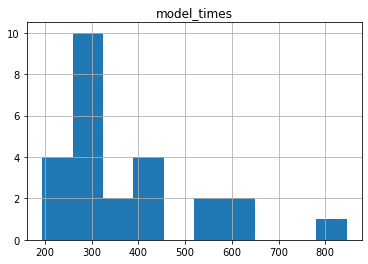

In [143]:
model_training_times = [325.44, 306.52, 290.09, 314.74, 297.0,
                       248.14, 437.23, 432.84, 266.68, 194.16,
                       212.96, 240.85, 268.2, 396.29, 299.04, 
                       280.25, 454.21, 620.86, 639.07, 307.15, 
                       845.34, 566.34, 313.77, 553.56, 378.98]

ttimes = pd.DataFrame({"model_times": model_training_times})
ttimes.hist()

In [144]:
ttimes.describe()

,model_times
count,25.0000
mean,379.5884
std,157.6771
min,194.1600
25%,280.2500
50%,313.7700
75%,437.2300
max,845.3400


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 16, 16, 128)      0         
 g2D)                                                            
                                                                 
 batch_normalization_46 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                                
                                                                 
 conv2d_49 (Conv2D)          (None, 16, 16, 256)       295168    
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 8, 8, 256)        0         
 g2D)                                                            
                                                     

2022-05-01 09:55:23.784773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 09:55:27.077937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 09:55:29.495779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 09:55:32.572549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 09:55:34.904990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 09:55:37.156245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 09:55:39.431968: I tensorflow/core/grappler/optimizers/cust

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1000
           1       0.91      0.97      0.94      1000
           2       0.83      0.79      0.81      1000
           3       0.79      0.69      0.74      1000
           4       0.88      0.81      0.84      1000
           5       0.91      0.71      0.80      1000
           6       0.72      0.97      0.83      1000
           7       0.92      0.91      0.91      1000
           8       0.95      0.91      0.93      1000
           9       0.88      0.93      0.90      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Accuracy Score: 0.8587
Root Mean Square Error: 1.521446679972716
Precision score: 0.864
Recall score: 0.859
Accuracy score: 0.859
F1 score: 0.857


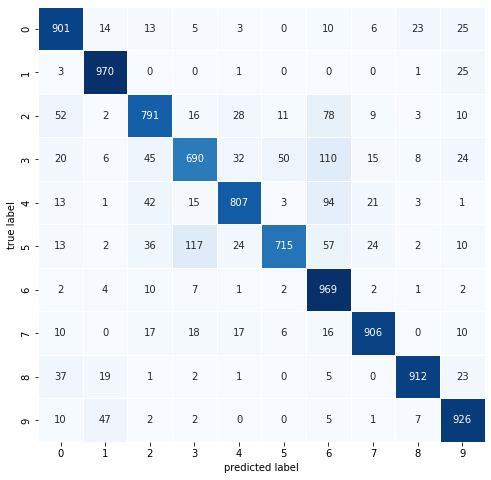

In [86]:
def multi_conv_test(models):
    
    models[0][0].model.summary()
    
    allPreds = []
    isFirst = True
    
    i = 0
    for m, hist in models:
        
        allPreds.insert(i, np.array(m.predict(x_test_norm)))
        i = i + 1
        
    #Use the mode of each model's predictions as the final value
    m = stats.mode(allPreds)
    pred_classes = m[0][0]
    
    print_validation_report(y_test, pred_classes)
    
    # Let's also print the accuracy and recall scores
    print("Precision score: {:.3f}".format(sklearn.metrics.precision_score(y_test, pred_classes, average='weighted')))
    print("Recall score: {:.3f}".format(sklearn.metrics.recall_score(y_test, pred_classes, average='weighted')))
    print("Accuracy score: {:.3f}".format(sklearn.metrics.accuracy_score(y_test, pred_classes)))
    print("F1 score: {:.3f}".format(sklearn.metrics.f1_score(y_test, pred_classes, average='weighted')))
    
    plot_confusion_matrix(y_test, pred_classes)
    
    return pred_classes
    
predictions = multi_conv_test(model_bag)

In [147]:
# Print the classification report for all 25 models:
for m, hist in model_bag:
    pred1 = m.predict(x_test_norm)
    print_validation_report(y_test, pred1)
    


Classification Report
              precision    recall  f1-score   support

           0       0.70      0.89      0.78      1000
           1       0.77      0.96      0.86      1000
           2       0.71      0.67      0.69      1000
           3       0.64      0.61      0.62      1000
           4       0.77      0.70      0.73      1000
           5       0.91      0.45      0.60      1000
           6       0.76      0.86      0.81      1000
           7       0.75      0.89      0.81      1000
           8       0.85      0.85      0.85      1000
           9       0.89      0.78      0.83      1000

    accuracy                           0.76     10000
   macro avg       0.77      0.76      0.76     10000
weighted avg       0.77      0.76      0.76     10000

Accuracy Score: 0.7647
Root Mean Square Error: 2.078557191900189
Classification Report
              precision    recall  f1-score   support

           0       0.66      0.91      0.76      1000
           1       0.84

array([[<AxesSubplot:title={'center':'model_acc'}>]], dtype=object)

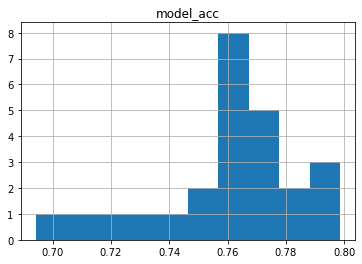

In [148]:
acc_scores = [0.7647, 0.7746, 0.7605, 0.6942, 0.7669,
             0.7677, 0.7669, 0.7764, 0.7438, 0.7164, 
             0.715, 0.7637, 0.7644, 0.7715, 0.7542, 
             0.7504, 0.7867, 0.7916, 0.7679, 0.7574, 
             0.7601, 0.7853, 0.7279, 0.7986, 0.7891]

macc = pd.DataFrame({"model_acc": acc_scores})
macc.hist()

In [26]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(directory='/Users/ramundson/Jupyter/MSDS_458_Public/MSDS458_Assignment_02/cifar-10/', 
                                            color_mode="rgb", 
                                            target_size=(32, 32), 
                                            class_mode=None, 
                                            classes=['test'],
                                            shuffle=False)



Found 300000 images belonging to 1 classes.


In [55]:
test_gen.reset()
p = model_single.predict(test_gen)

df = pd.DataFrame(p[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,0.54%,0.11%,8.21%,6.13%,81.71%,1.43%,0.33%,1.13%,0.27%,0.16%
1,1.31%,0.44%,6.08%,24.12%,19.48%,21.24%,8.80%,14.87%,1.35%,2.31%
2,0.01%,0.00%,19.01%,0.14%,80.34%,0.02%,0.48%,0.00%,0.00%,0.00%
3,1.06%,0.10%,21.67%,1.40%,59.22%,2.83%,3.79%,8.37%,0.23%,1.33%
4,0.36%,0.02%,12.04%,12.27%,23.74%,5.02%,46.07%,0.39%,0.03%,0.05%
5,0.02%,0.05%,6.13%,4.24%,58.72%,7.22%,22.47%,0.72%,0.05%,0.37%
6,0.01%,0.00%,0.07%,0.01%,99.82%,0.05%,0.01%,0.04%,0.00%,0.00%
7,4.02%,0.27%,3.35%,13.39%,12.97%,26.92%,34.62%,0.34%,2.01%,2.12%
8,0.12%,0.16%,2.76%,13.62%,18.26%,7.42%,56.25%,0.71%,0.19%,0.51%
9,0.01%,82.21%,0.00%,0.00%,0.00%,0.06%,0.04%,0.00%,0.44%,17.23%


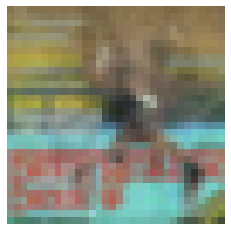

In [66]:
test_gen.reset()
plt.imshow(test_gen.next()[0], cmap='viridis')
plt.axis('off')
plt.show()

In [87]:
def multi_conv_kaggle(models):
    
    allPreds = []
    isFirst = True
    
    i = 0
    for m, hist in models:
        test_gen.reset()
        allPreds.insert(i, np.array(m.predict(test_gen)))
        i = i + 1
        
    #Use the mode of each model's predictions as the final value
    m = stats.mode(allPreds)
    pred_classes = m[0][0]
    sub = pd.read_csv('/Users/ramundson/Jupyter/MSDS_458_Public/MSDS458_Assignment_02/cifar-10/sampleSubmission.csv', header='infer')
    
    sub['label'] = np.vectorize(lambda x: class_names[x])(pred_classes)
    
    test_gen.reset()
    sub['id'] = [int(x.split("/")[1][:-4]) for x in test_gen.filenames]
    sub.to_csv('submission.csv',index=False)
    
    return pred_classes
    
predictions = multi_conv_kaggle(model_bag)

2022-05-01 09:57:40.462148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 09:58:56.656588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 10:00:12.561464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 10:01:28.267257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 10:02:50.697095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 10:04:08.322086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 10:05:42.957395: I tensorflow/core/grappler/optimizers/cust

In [150]:
!pip install -U notebook-as-pdf

  Using cached notebook_as_pdf-0.5.0-py3-none-any.whl (6.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.0/80.0 KB 960.1 kB/s eta 0:00:00 0:00:01
  Using cached pyppeteer-1.0.2-py3-none-any.whl (83 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
  Using cached pyee-8.2.2-py2.py3-none-any.whl (12 kB)
  Using cached websockets-10.3-cp39-cp39-macosx_11_0_arm64.whl (97 kB)


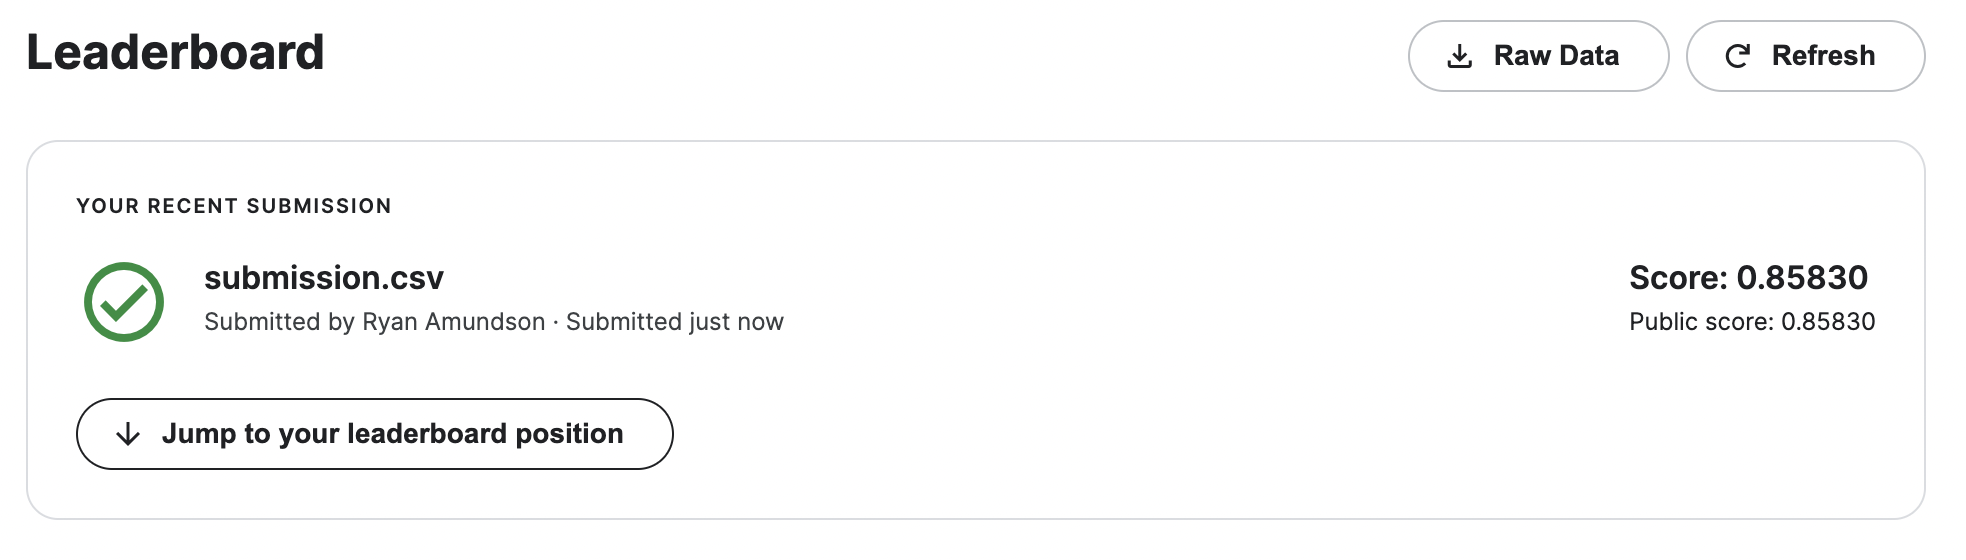

In [151]:
%%bash 

jupyter-nbconvert --to PDFviaHTML MSDS458_Assignment_02_20220325_v22_COLAB_Part1.ipynb

[NbConvertApp] Converting notebook MSDS458_Assignment_02_20220325_v22_COLAB_Part1.ipynb to PDFviaHTML
[NbConvertApp] Writing 6136183 bytes to MSDS458_Assignment_02_20220325_v22_COLAB_Part1.pdf
